In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from konlpy.tag import Mecab
mecab = Mecab()

#import lightgbm as lgb

import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
df = pd.read_csv('./data/train.csv')

In [3]:
def parse_sentence(sentence):
    ret = []
    nouns = []
    condition = False
    for word in mecab.pos(sentence):
        # 계시다면 등에서 다면이 N으로 파싱됨
        if word[1][:1] == 'N':
            if word[0][:2] in ('경우', '필요', '라면', '다면'): # 경우, 필요 단어 등장 시 조건절로 판단
                condition = True
            else:
                nouns.append(word[0])
        # 도 : 여도, 라도
        # 면 : 라면, 면
        elif word[1] == 'EC' and (word[0][-1:] in ('면', '도') or word[0][-2:] in ('도록')):
            condition = True
        elif word[1][-2:] in ('EF'): # and word[0][-1:] in ['요', '다']:
            ret.append((word[0], condition, nouns))
            nouns = []
            condition = False
    if len(nouns) > 0:
        ret.append((word[0], condition, nouns))
    return ret

In [4]:
smishings = []
normals = []
idx = 0
for idx, item in df.iterrows():
    #print(item.text)
    splited = parse_sentence(item.text)
    splited.append(item.id)
    #splited = m.parse(item.text).split()
    if item.smishing == 1:
        smishings.append(splited)
    else:
        normals.append(splited)
    if idx % 100000 == 0:
        print(datetime.now(), idx)
    idx += 1
#     if idx > 20000:
#         break

2019-12-22 11:27:39.177602 0
2019-12-22 11:28:18.786486 100000
2019-12-22 11:29:05.924474 200000


In [5]:
class wordCounter():
    def __init__(self):
        self.word_bank = {}
    
    def add_bucket(self, bucket_name):
        self.word_bank[bucket_name] = {}
        
    def add_list(self, bucket_name, word_list:[]):
        bucket = self.word_bank[bucket_name]
        for keyword in word_list:
            if keyword in bucket:
                bucket[keyword] += 1
            else:
                bucket[keyword] = 1
                
    def get_counts(self, bucket_name):
        return self.word_bank[bucket_name]

In [6]:
wc = wordCounter()
wc.add_bucket('conditioned')
wc.add_bucket('general')

for normal in normals:
    for item in normal[:-1]:
        if item[1] == True:
            wc.add_list('conditioned', item[2])
        else:
            wc.add_list('general', item[2])

for smishing in smishings:
    for item in smishing[:-1]:
        if item[1] == True:
            wc.add_list('conditioned', item[2])
        else:
            wc.add_list('general', item[2])

In [7]:
cond_test = pd.Series(wc.get_counts('conditioned'))
cond_test[cond_test.index.map(len) > 1].head(5)

첫날        37
누군가      242
행복      7022
문자     24824
라운지      533
dtype: int64

In [8]:
conditioned_df = pd.Series(wc.get_counts('conditioned'))
general_df = pd.Series(wc.get_counts('general'))

# 글자가 2개 이상인 것만 모아보자
conditioned_df = conditioned_df[conditioned_df.index.map(len) > 1]
general_df = general_df[general_df.index.map(len) > 1]

# 출현빈도가 일정 개수 이상되는 키워드만 표시해보면
display(conditioned_df[conditioned_df > 50])  # 조건절이 있는 문장에서 출현 빈도
display(general_df[general_df > 500])

누군가      242
행복      7022
문자     24824
라운지      533
이용     11239
       ...  
대성       125
신전        53
자채        92
자절       316
채팅       503
Length: 1571, dtype: int64

행성        683
팀장      31276
행복     102438
주말      49903
오늘      30588
        ...  
전폭        560
이용자       583
도최       1497
사대        968
승인서       660
Length: 1087, dtype: int64

In [9]:
# size of feature vector : 아래 두 숫자를 합한 것만큼이 피쳐개수가 됨 \ 위의 출현개수 기반으로 판단해볼것
# 참고 : 400/400 에서 늘려서.. 700/500 800/400 600/600 이렇게 해봐도.. 아래 케이스에서 못맞히는 개수가 12~14개 꾸준함... ㅎㅎ
# 400/400 일 때는 15개 틀림.. 좀 늘리면 12개 까지는 좋아질 수 있음.. 합이 1200을 넘으면 너무 느려져서 사용불가 (이 mac기준)
CONDITION_WORD_FTR_SIZE = 250  
GENERAL_WORD_FTR_SIZE = 350

conditioned_dic = list(conditioned_df.sort_values(ascending=False).head(CONDITION_WORD_FTR_SIZE).index)
general_dic = list(general_df.sort_values(ascending=False).head(GENERAL_WORD_FTR_SIZE).index)

In [10]:
train_normal = []
train_smishing = []
train_conditioned = []
train_general = []

In [11]:
original_idx = []
for normal in normals:
    # 하나의 문자메시지에서 여러개의 문장이 있을 때, 한문장씩 처리(조건절 있는 경우 없는경우 나눠서)
    conditioned = []
    general = []
    for item in normal[:-1]:
        if item[1] == True:  # conditioned
            conditioned += [x for x in item[2] if x in conditioned_dic]
        else:
            general += [x for x in item[2] if x in general_dic]
    train_conditioned.append(list(conditioned))
    train_general.append(list(general))
    original_idx.append(normal[-1])

In [12]:
for smishing in smishings:
    # 하나의 문자메시지에서 여러개의 문장이 있을 때, 한문장씩 처리(조건절 있는 경우 없는경우 나눠서)
    conditioned = []
    general = []
    for item in smishing[:-1]:
        if item[1] == True:  # conditioned
            conditioned += [x for x in item[2] if x in conditioned_dic]
        else:
            general += [x for x in item[2] if x in general_dic]
    train_conditioned.append(list(conditioned))
    train_general.append(list(general))
    original_idx.append(smishing[-1])

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_conditioned = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
vectorizer_general = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)

tidf_conditioned = vectorizer_conditioned.fit_transform(train_conditioned)
tidf_general = vectorizer_general.fit_transform(train_general)

In [14]:
# 훈련용, 훈련검증용, 결과검증용 분리
tidf_conditioned = np.array(tidf_conditioned.toarray())
tidf_general = np.array(tidf_general.toarray())
tidf_label = np.array([1 if x >= len(normals) else 0 for x in range(tidf_conditioned.shape[0])])

np.random.seed(0)
split = np.random.rand(tidf_conditioned.shape[0])
tidf_cond_train = tidf_conditioned[split < 0.6]
tidf_cond_valid = tidf_conditioned[(split >= 0.6) & (split < 0.8)]
tidf_cond_test = tidf_conditioned[split >= 0.8]

tidf_gen_train = tidf_general[split < 0.6]
tidf_gen_valid = tidf_general[(split >= 0.6) & (split < 0.8)]
tidf_gen_test = tidf_general[split >= 0.8]

tidf_label_train = tidf_label[split < 0.6]
tidf_label_valid = tidf_label[(split >= 0.6) & (split < 0.8)]
tidf_label_test = tidf_label[split >= 0.8]

tidf_cond_train.shape, tidf_cond_valid.shape #, tidf_cond_test.shape

((177533, 250), (59281, 250))

In [15]:
tidf_gen_train.shape, tidf_gen_valid.shape #, tidf_gen_test.shape

((177533, 350), (59281, 350))

In [30]:
n_cond, n_gen = CONDITION_WORD_FTR_SIZE, GENERAL_WORD_FTR_SIZE
cond_input = keras.layers.Input(shape=(n_cond,), name='Cond')
gen_input = keras.layers.Input(shape=(n_gen,), name='General')

#cond_vec_mlp = keras.layers.Embedding(n_cond, num_predictive_factors, )(cond_input)
#cond_vec_mlp = keras.layers.Flatten(name='Flattenconds-MLP')(cond_vec_mlp)
#cond_vec_mlp = keras.layers.Dropout(0.3)(cond_vec_mlp)

#gen_vec_mlp = keras.layers.Embedding(n_gen, num_predictive_factors)(gen_input)
#gen_vec_mlp = keras.layers.Flatten(name='Flattengens-MLP')(gen_vec_mlp)
#gen_vec_mlp = keras.layers.Dropout(0.3)(gen_vec_mlp)

concat_mlp = keras.layers.merge.concatenate([cond_input, gen_input])
#concat_dropout_mlp = keras.layers.Dropout(0.3)(concat_mlp)

dense = keras.layers.Dense(64, name='FullyConnected-1')(concat_mlp)
dropout_1 = keras.layers.Dropout(0.3, name='Dropout-1')(dense)

# dense_2 = keras.layers.Dense(128, name='FullyConnected-2')(dropout_1)
# dropout_2 = keras.layers.Dropout(0.3, name='Dropout-2')(dense_2)

# dense_3 = keras.layers.Dense(512, name='FullyConnected-3')(dropout_2)
# dropout_3 = keras.layers.Dropout(0.2, name='Dropout-3')(dense_3)

dense_4 = keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.0025), name='FullyConnected-4', activation='relu')(dropout_1)

pred_mlp = keras.layers.Dense(1, activation='sigmoid', name='Activation')(dense_4)

model = keras.Model(inputs=[cond_input, gen_input], output=pred_mlp)
model.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss='mae', metrics=['mae', 'accuracy'])

/home/xikizima/.conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("Ac...)`


In [31]:
tidf_label_valid.shape, sum(tidf_label_valid)

((59281,), 3724)

In [32]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, tidf_cond_train, tidf_gen_train, tidf_label_train, normal_size=160, smishing_size=160):
        self.tidf_cond_train_normal = tidf_cond_train[tidf_label_train == 0]
        self.tidf_gen_train_normal = tidf_gen_train[tidf_label_train == 0]
        self.tidf_cond_train_smishing = tidf_cond_train[tidf_label_train == 1]
        self.tidf_gen_train_smishing = tidf_gen_train[tidf_label_train == 1]
        self.normal_sample_size = normal_size
        self.smishing_sample_size = smishing_size
        # 2로 나눠서 전체의 50%만 샘플링해보자
        self.num_batch = int(np.ceil(len(self.tidf_cond_train_normal) / (self.normal_sample_size + self.smishing_sample_size) / 2))
        print('num_batch:', self.num_batch)
    
    def __len__(self):
        return self.num_batch
    
    def __getitem__(self, index):
        # random sampling. ignore index
        normal_sampling = np.random.choice(len(self.tidf_cond_train_normal), self.normal_sample_size)
        normal_cond_sample = self.tidf_cond_train_normal[normal_sampling]
        normal_gen_sample = self.tidf_gen_train_normal[normal_sampling]
        smishing_sampling = np.random.choice(len(self.tidf_cond_train_smishing), self.smishing_sample_size)
        smishing_cond_sample = self.tidf_cond_train_smishing[smishing_sampling]
        smishing_gen_sample = self.tidf_gen_train_smishing[smishing_sampling]
        sample_cond_train = np.concatenate([normal_cond_sample, smishing_cond_sample])
        sample_gen_train = np.concatenate([normal_gen_sample, smishing_gen_sample])
        sample_label_train = [1 if x >= self.normal_sample_size else 0 for x in range(len(sample_cond_train))]
        return [sample_cond_train, sample_gen_train], sample_label_train

    def on_epoch_end(self):
        pass

In [33]:
train_gen = DataGenerator(tidf_cond_train, tidf_gen_train, tidf_label_train, 320, 160)
valid_gen = DataGenerator(tidf_cond_valid, tidf_gen_valid, tidf_label_valid, 16000, 1000)

history = model.fit_generator(generator=train_gen,
                             epochs = 50,
#                              use_multiprocessing=True,
#                               workers=3,
                             validation_data=valid_gen,
                             verbose=1)

num_batch: 174
num_batch: 2
Epoch 1/50
174/174 [==============================] - 2s 11ms/step - loss: 0.5571 - mean_absolute_error: 0.4080 - acc: 0.8819 - val_loss: 0.4696 - val_mean_absolute_error: 0.3272 - val_acc: 0.9804
Epoch 2/50
174/174 [==============================] - 1s 6ms/step - loss: 0.3056 - mean_absolute_error: 0.1665 - acc: 0.9892 - val_loss: 0.2307 - val_mean_absolute_error: 0.0961 - val_acc: 0.9944
Epoch 3/50
174/174 [==============================] - 1s 6ms/step - loss: 0.1828 - mean_absolute_error: 0.0556 - acc: 0.9939 - val_loss: 0.1574 - val_mean_absolute_error: 0.0385 - val_acc: 0.9962
Epoch 4/50
174/174 [==============================] - 1s 6ms/step - loss: 0.1394 - mean_absolute_error: 0.0296 - acc: 0.9953 - val_loss: 0.1232 - val_mean_absolute_error: 0.0226 - val_acc: 0.9975
Epoch 5/50
174/174 [==============================] - 1s 6ms/step - loss: 0.1121 - mean_absolute_error: 0.0200 - acc: 0.9971 - val_loss: 0.1005 - val_mean_absolute_error: 0.0166 - val_acc

174/174 [==============================] - 1s 6ms/step - loss: 0.0033 - mean_absolute_error: 0.0017 - acc: 0.9992 - val_loss: 0.0027 - val_mean_absolute_error: 0.0012 - val_acc: 0.9994
Epoch 43/50
174/174 [==============================] - 1s 6ms/step - loss: 0.0033 - mean_absolute_error: 0.0018 - acc: 0.9990 - val_loss: 0.0025 - val_mean_absolute_error: 0.0011 - val_acc: 0.9997
Epoch 44/50
174/174 [==============================] - 1s 6ms/step - loss: 0.0032 - mean_absolute_error: 0.0018 - acc: 0.9989 - val_loss: 0.0023 - val_mean_absolute_error: 9.5887e-04 - val_acc: 0.9997
Epoch 45/50
174/174 [==============================] - 1s 6ms/step - loss: 0.0034 - mean_absolute_error: 0.0021 - acc: 0.9986 - val_loss: 0.0021 - val_mean_absolute_error: 8.1476e-04 - val_acc: 0.9997
Epoch 46/50
174/174 [==============================] - 1s 6ms/step - loss: 0.0029 - mean_absolute_error: 0.0016 - acc: 0.9991 - val_loss: 0.0022 - val_mean_absolute_error: 9.4600e-04 - val_acc: 0.9997
Epoch 47/50
174

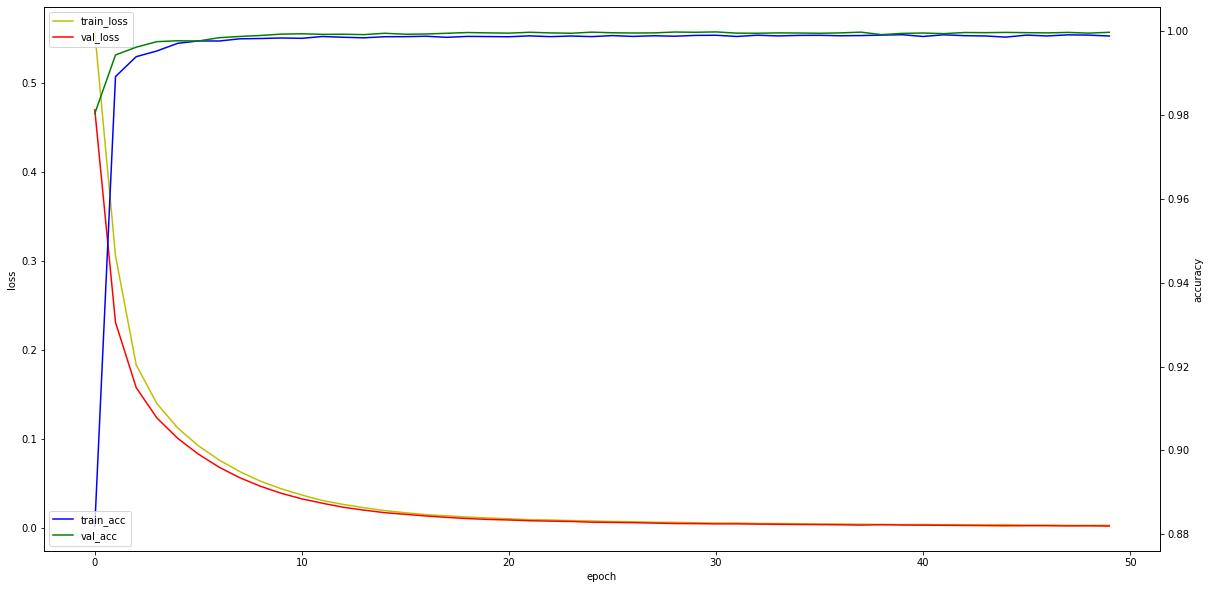

In [34]:
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
acc_ax = loss_ax.twinx()
loss_ax.plot(history.history['loss'], 'y', label='train_loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val_loss')

acc_ax.plot(history.history['acc'], 'b', label='train_acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val_acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [38]:
gap > 0.5

array([False, False, False, ..., False, False, False])

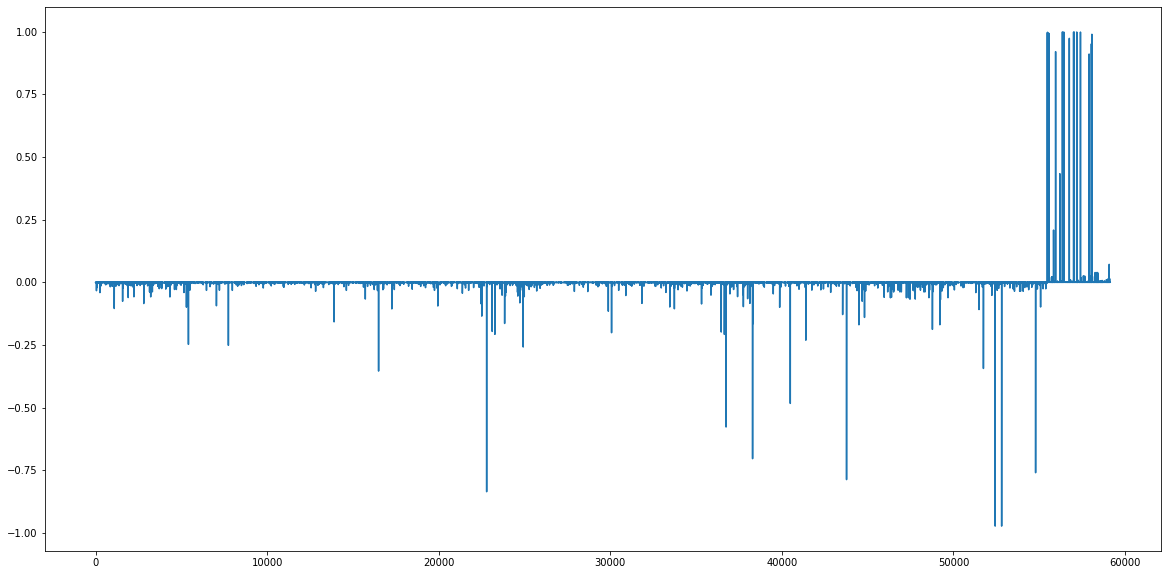

In [35]:
# 결과검증(overfit, underfit)
pred_test = model.predict(x=[tidf_cond_test, tidf_gen_test], batch_size=320)
gap = tidf_label_test - pred_test.reshape([-1,])

plt.figure(figsize=(20,10))
plt.plot(gap)

In [45]:
df[df['id'].isin(np.array(original_idx)[split >= 0.8][gap > 0.5])].text.map(print)

(광고)XXX신년특별빠르게천만원월39000원통화1번(무료거부XXX-XXX-XXX)
(광고) 정관장에서 미리 설 준비하시고 특별한 혜택 받으세요!! 예약기간 : 13(화)  19(월) 행사내용 :- 밝을윤세트 은혜은세트 원앙세트 3종 구매 예약시 5% 포인트 추가 적립- 예약방법은 매장으로 문의하여 주세요. 20만원 XXX입 시 1만원 할인- 기간:11128까지적용카드: 현대이마트카드.삼성카드.XXX국민카드.현대카드.XXX카드 결재 시 적용됨. 예약문의 : 정관장 서울 이마트가양점 전화:XX-XXX-XXX 무료수신거부 : XXX-XXX-XXX(광고)정관장 사전예XXX
SK텔레콤 2017년 1월 XXX이번달 납부하실 금액은 20650원 입니다.XXX 고객번호 : 010-16-3505 자동납부접수번호 : XXX-XXX-XXX 납기일 : 2017.1.23. 말일이 지나면 2%의 가산금이 두 달 후에 청구됩니다.이번달 금액 상세내역 단말기할부금 단말기할부금() - 단말기할부원금 : 20450원 - 단말기할부이자 : 200원 이번달금액 : 20650원 단말기 할부 대수 : 1대 단말기 총 할부금 : 743616원(총 할부개월 : 36개월) 단말기할부금 잔액 : 40056원(잔여개월 : 2개월) 자동납부은행 : XXX 계좌번호 : 고객요청에 의한 미기재 인출예정일 : 2017.1.23. ()표시 항목은 당사에서 청구 대행하는 타사 요금입니다. 표시 항목은 부가가치세 제외 대상입니다. 고객님께서 요청하신 번호로 문자XXX를 보내드리오니 이동전화번호가 변경될 경우 SK텔레콤 고객센터로 연락바랍니다. 1월 5일 기준으로 작성된 금액입니다.SK텔레콤 문자 XXX
피플라이프재무설계XXX팀장입니다 이번에찾아뵙는 금융서비스라고해서은행 예.적금CMAMMF 등관련하여 1:1 재무설계를직접 찾아뵙고 무료상담을 도와드리고있습니다Ex) 현재-시중은행 1.25% 금리이용하시는분들같은 경우상담후-최저보증2.9% 비과세상품 이용하실수있는 방법을 기본베이스로안내를 도와드리고XXX고객님께서 가입되어있는

440       None
938       None
5711      None
6221      None
76671     None
137858    None
138214    None
149795    None
186024    None
195865    None
196896    None
208304    None
223491    None
252122    None
255484    None
256005    None
256306    None
Name: text, dtype: object

auc : 0.9998555465352693


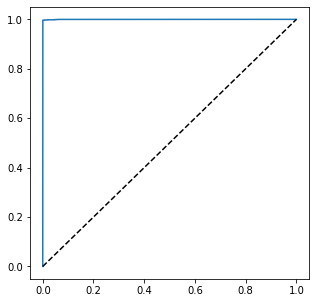

In [36]:
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import auc
from matplotlib import pyplot as plt

fpr, tpr, thresholds = roc_curve(tidf_label_test, pred_test)
print('auc :', auc(fpr,tpr))

plt.figure(figsize=(5,5))
plt.plot(fpr,tpr,'-')
plt.plot([0,1],[0,1], 'k--')
plt.show()

In [46]:
mecab.pos("""피플라이프재무설계XXX팀장입니다 이번에찾아뵙는 금융서비스라고해서은행 예.적금CMAMMF 등관련하여 1:1 재무설계를직접 찾아뵙고 무료상담을 도와드리고있습니다Ex) 현재-시중은행 1.25% 금리이용하시는분들같은 경우상담후-최저보증2.9% 비과세상품 이용하실수있는 방법을 기본베이스로안내를 도와드리고XXX고객님께서 가입되어있는 금융상품들을 다시한번 점검및진단을 함으로써개개인의 현금흐름표에 맞게(목돈마련결혼자금노후자금 등)맞춤형 포트폴리오 또한 안내를 드리고있습니다.평소 바쁘시다보니 전문가에게 이런 안내와 상담서비스를 받아보시지 못하셨을텐데 무료상담을 원하시면직접 집이나 회사앞까지 찾아뵙는 서비스이기XXX 시간절약도 하실수가 있습니다.현재 높은만족도와 많은혜택들을 받으시고 있기XXX 고객님께서도상담신청이라고 답장을 남겨주시면일정 확인차 전화를 드리겠습니다.감사합니다.제목없음""")

[('피플', 'NNP'),
 ('라이프', 'NNG'),
 ('재무', 'NNG'),
 ('설계', 'NNG'),
 ('XXX', 'SL'),
 ('팀장', 'NNG'),
 ('입니다', 'VCP+EF'),
 ('이번', 'NNG'),
 ('에', 'JKB'),
 ('찾아뵙', 'VV'),
 ('는', 'ETM'),
 ('금융', 'NNG'),
 ('서비스', 'NNG'),
 ('라고', 'VCP+EC'),
 ('해서', 'VV+EC'),
 ('은행', 'NNG'),
 ('예', 'IC'),
 ('.', 'SF'),
 ('적금', 'NNG'),
 ('CMAMMF', 'SL'),
 ('등', 'NNB'),
 ('관련', 'NNG'),
 ('하', 'XSA'),
 ('여', 'EC'),
 ('1', 'SN'),
 (':', 'SC'),
 ('1', 'SN'),
 ('재무', 'NNG'),
 ('설계', 'NNG'),
 ('를', 'JKO'),
 ('직접', 'MAG'),
 ('찾아뵙', 'VV'),
 ('고', 'EC'),
 ('무료', 'NNG'),
 ('상담', 'NNG'),
 ('을', 'JKO'),
 ('도와', 'VV+EC'),
 ('드리', 'VX'),
 ('고', 'EC'),
 ('있', 'VX'),
 ('습니다', 'EF'),
 ('Ex', 'SL'),
 (')', 'SSC'),
 ('현재', 'NNG'),
 ('-', 'SY'),
 ('시중', 'NNG'),
 ('은행', 'NNG'),
 ('1', 'SN'),
 ('.', 'SY'),
 ('25', 'SN'),
 ('%', 'SY'),
 ('금리', 'NNG'),
 ('이용', 'NNG'),
 ('하', 'XSV'),
 ('시', 'EP'),
 ('는', 'ETM'),
 ('분', 'NNB'),
 ('들', 'XSN'),
 ('같', 'VA'),
 ('은', 'ETM'),
 ('경우', 'NNG'),
 ('상담', 'NNG'),
 ('후', 'NNG'),
 ('-', 'SY'),
 ('최저', 

In [49]:
mecab.pos("""XXX 고객님 안녕하세요XXX은행 무교지점 XXX과장입니다 오늘 아침에 눈을 뜨니 눈이 많이 와서 온 세상이 하얗게 변했더군요어릴적에는 눈이 마냥 좋기만 했는데눈을 보는 순간 좋기보다는 먼저. 출근을 걱정하게 되더라구요이제 진정한 어른이 되었음을 느끼게 됩니다새해 인사를 드리기전에..제가 발령이 나서 본점으로 가게되었어요ㅠㅠ. 진정한 구정 새해인사보다 이별인사를 먼저 드리게 되어 송구할 뿐입니다그동안 보내주신 성원에 감사.또 감사드리며XXX은행에 있는XXX고객님을 평생 저의 고객으로 모시겠습니다.새해 복 많이 받으시고 2017년 원하고 바라시는 모든일 이루시길 기원합니다XXX은행 무교지점 XXX과장올림""")

[('XXX', 'SL'),
 ('고객', 'NNG'),
 ('님', 'XSN'),
 ('안녕', 'NNG'),
 ('하', 'XSV'),
 ('세요', 'EP+EF'),
 ('XXX', 'SL'),
 ('은행', 'NNG'),
 ('무교', 'NNG'),
 ('지점', 'NNG'),
 ('XXX', 'SL'),
 ('과장', 'NNG'),
 ('입니다', 'VCP+EF'),
 ('오늘', 'MAG'),
 ('아침', 'NNG'),
 ('에', 'JKB'),
 ('눈', 'NNG'),
 ('을', 'JKO'),
 ('뜨', 'VV'),
 ('니', 'EC'),
 ('눈', 'NNG'),
 ('이', 'JKS'),
 ('많이', 'MAG'),
 ('와서', 'VV+EC'),
 ('온', 'VX+ETM'),
 ('세상', 'NNG'),
 ('이', 'JKS'),
 ('하얗', 'VA'),
 ('게', 'EC'),
 ('변했', 'VV+EP'),
 ('더군요', 'EC'),
 ('어릴', 'VA+ETM'),
 ('적', 'NNB'),
 ('에', 'JKB'),
 ('는', 'JX'),
 ('눈', 'NNG'),
 ('이', 'JKS'),
 ('마냥', 'MAG'),
 ('좋', 'VA'),
 ('기', 'ETN'),
 ('만', 'JX'),
 ('했', 'VV+EP'),
 ('는데', 'EC'),
 ('눈', 'NNG'),
 ('을', 'JKO'),
 ('보', 'VV'),
 ('는', 'ETM'),
 ('순간', 'NNG'),
 ('좋', 'VA'),
 ('기', 'ETN'),
 ('보다', 'JKB'),
 ('는', 'JX'),
 ('먼저', 'MAG'),
 ('.', 'SF'),
 ('출근', 'NNG'),
 ('을', 'JKO'),
 ('걱정', 'NNG'),
 ('하', 'XSV'),
 ('게', 'EC'),
 ('되', 'VV'),
 ('더라구요', 'EF'),
 ('이제', 'MAG'),
 ('진정', 'XR'),
 ('한', 'XSA+ETM'),
 (

In [48]:
df.head(10).text.map(print)

XXX은행성산XXX팀장입니다.행복한주말되세요
오늘도많이웃으시는하루시작하세요XXX은행 진월동VIP라운지 XXX올림
안녕하십니까 고객님. XXX은행입니다.금일 납부하셔야 할 금액은 153600원 입니다.감사합니다. 새해 복 많이 받으십시오.XXX은행옥포XXX올림
XXX 고객님안녕하세요XXX은행 XXX지점입니다지난 한 해 동안 저희 XXX지점에 보내주신 성원에 감사드립니다. 설렘으로 시작한 2017년소망하시는 일 모두 이XXX 고객님의 가정에 늘 건강과 행복이 함께하길 기원하겠습니다. 사랑하는 가족과 함께 정을 나누는 행복한 설 명절 보내세요 XXX은행 XXX지점직원일동
1월은 새로움이 가득XXX입니다.올 한해 더 많이행복한 한해되시길바랍니다
행복한주말보내세요XXX용현남전담직원대리 XXX올림
XXX 고객님 안녕하세요XXX은행 무교지점 XXX과장입니다 오늘 아침에 눈을 뜨니 눈이 많이 와서 온 세상이 하얗게 변했더군요어릴적에는 눈이 마냥 좋기만 했는데눈을 보는 순간 좋기보다는 먼저. 출근을 걱정하게 되더라구요이제 진정한 어른이 되었음을 느끼게 됩니다새해 인사를 드리기전에..제가 발령이 나서 본점으로 가게되었어요ㅠㅠ. 진정한 구정 새해인사보다 이별인사를 먼저 드리게 되어 송구할 뿐입니다그동안 보내주신 성원에 감사.또 감사드리며XXX은행에 있는XXX고객님을 평생 저의 고객으로 모시겠습니다.새해 복 많이 받으시고 2017년 원하고 바라시는 모든일 이루시길 기원합니다XXX은행 무교지점 XXX과장올림
XXX 고객님지난 한해 베풀어 주신 은혜 진심으로 감사 드립니다.가슴 깊이 간직 하겠습니다.정유년 새해 가족 모두 행복하시고 뜻 하는 바 모두이루시길 진심으로 소망합니다XXX XXX은행 XXX 지점장               정 XXX 배상
설연휴 가족들과 훈훈한 정 나누시고 정겨운추억 많이 만드세요XXX오XXX올림
(광고)XXXBaXXX고객님들 뒤엔XXX 언제나 XXX새로운 마음가짐으로 새롭게 준비합니다.당행상품의 자격기준과 심사기준이 완화되어 상품에 대해 간단하게 상품정보 전

0    None
1    None
2    None
3    None
4    None
5    None
6    None
7    None
8    None
9    None
Name: text, dtype: object

In [ ]:
0.999886801482348  #  64 64 l1_0.0035, sigmoid A

In [ ]:
0.999870406857598 # 제출 (32, 32_l2_0.01, sigmoid, Adam_1e-4)

In [ ]:
# 제출 준비

In [51]:
submit_df = pd.read_csv('./data/public_test.csv')

In [52]:
unknowns = []

idx = 0
for idx, item in submit_df.iterrows():
    splited = parse_sentence(item.text)
    splited.append(item.id)
    unknowns.append(splited)
    if idx % 100000 == 0:
        print(datetime.now(), idx)
    idx += 1

2019-12-22 10:56:09.258422 0


In [53]:
test_conditioned = []
test_general = []

original_idx = []
for unknown in unknowns:
    conditioned = []
    general = []
    for item in unknown[:-1]:
        if item[1] == True:
            conditioned += [x for x in item[2] if x in conditioned_dic]
        else:
            general += [x for x in item[2] if x in general_dic]
    test_conditioned.append(list(conditioned))
    test_general.append(list(general))
    original_idx.append(unknown[-1])

In [54]:
tidf_conditioned = vectorizer_conditioned.transform(test_conditioned).toarray()
tidf_general = vectorizer_general.transform(test_general).toarray()

In [55]:
pred_y = model.predict(x=[tidf_conditioned, tidf_general], verbose=1)

1626/1626 [==============================] - 0s 35us/step


In [56]:
pred_y[pred_y > 1.0] = 1.0

In [57]:
submit_df['smishing'] = np.abs(pred_y)

In [58]:
submit_df[['id', 'smishing']].to_csv('./data/submission_20191222_1.csv', index=False)